# P1.2 QUANTUM NN
Alejando Mayorga Redondo
Fernando Mondragón Sampedro

### Introducción


En esta práctica, realizaremos la implementación de una red neuronal cuántica la cual permita clasificar vinos en base a 3 categorías distintas, partiendo de 13 características tales como volumen de alcohol o acidez. 

### Preprocesado

Primeramente, es necesario realizar un preprocesado de los datos, de forma que se ajusten a una entrada manipulable por la red, para esto, dividimos las características y etiquetas en conjuntos de entrenamiento y test, para después llamar a la función MinMaxScaler, encargada de normalizar los datos, para después aplicar una función de one hot encoder, que nos permite disponer las etiquetas de forma adecuada para su clasificación en una de las tres categorías.

In [89]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC

wine_data = load_wine()
features = wine_data.data
labels = wine_data.target
num_features = features.shape[1]


features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20)

features_train = MinMaxScaler().fit_transform(features_train)

features_test = MinMaxScaler().fit_transform(features_test)

#encoder = OneHotEncoder()
#train_labels_oh = encoder.fit_transform(labels_train.reshape(-1, 1)).toarray()
#test_labels_oh = encoder.fit_transform(labels_test.reshape(-1, 1)).toarray()




### Desarrollo de la QNN


#### State preparation

Ahora debemos de preparar el circuíto que nos permitirá realizar la clasificación. De entre todas las posibles opciones para armarlo, decidimo optar por ZZFeatureMap debido a ?

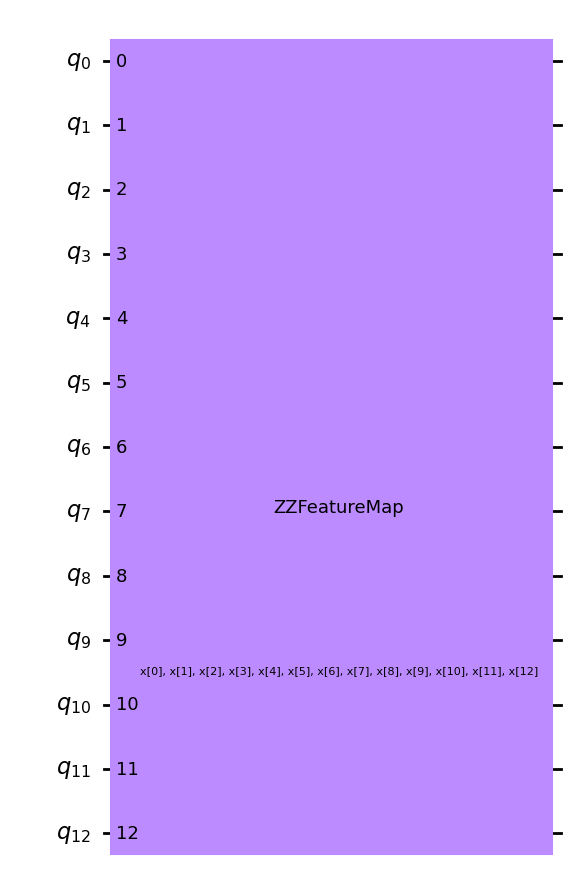

In [15]:
#Primero escogemos un método de encoding para las features. En nuestro caso optamos por el ZZFeatureMap
from qiskit.circuit.library import ZZFeatureMap
featureMap = ZZFeatureMap(feature_dimension=13, reps=1)
#featureMap.decompose().draw("mpl")
featureMap.draw("mpl")


#### Circuito clasificador


Para realizar la clasificación persé, es necesario crear otro circuíto conocido como modelo. Para este fin, empleamos el TwoLocal debido a ? 

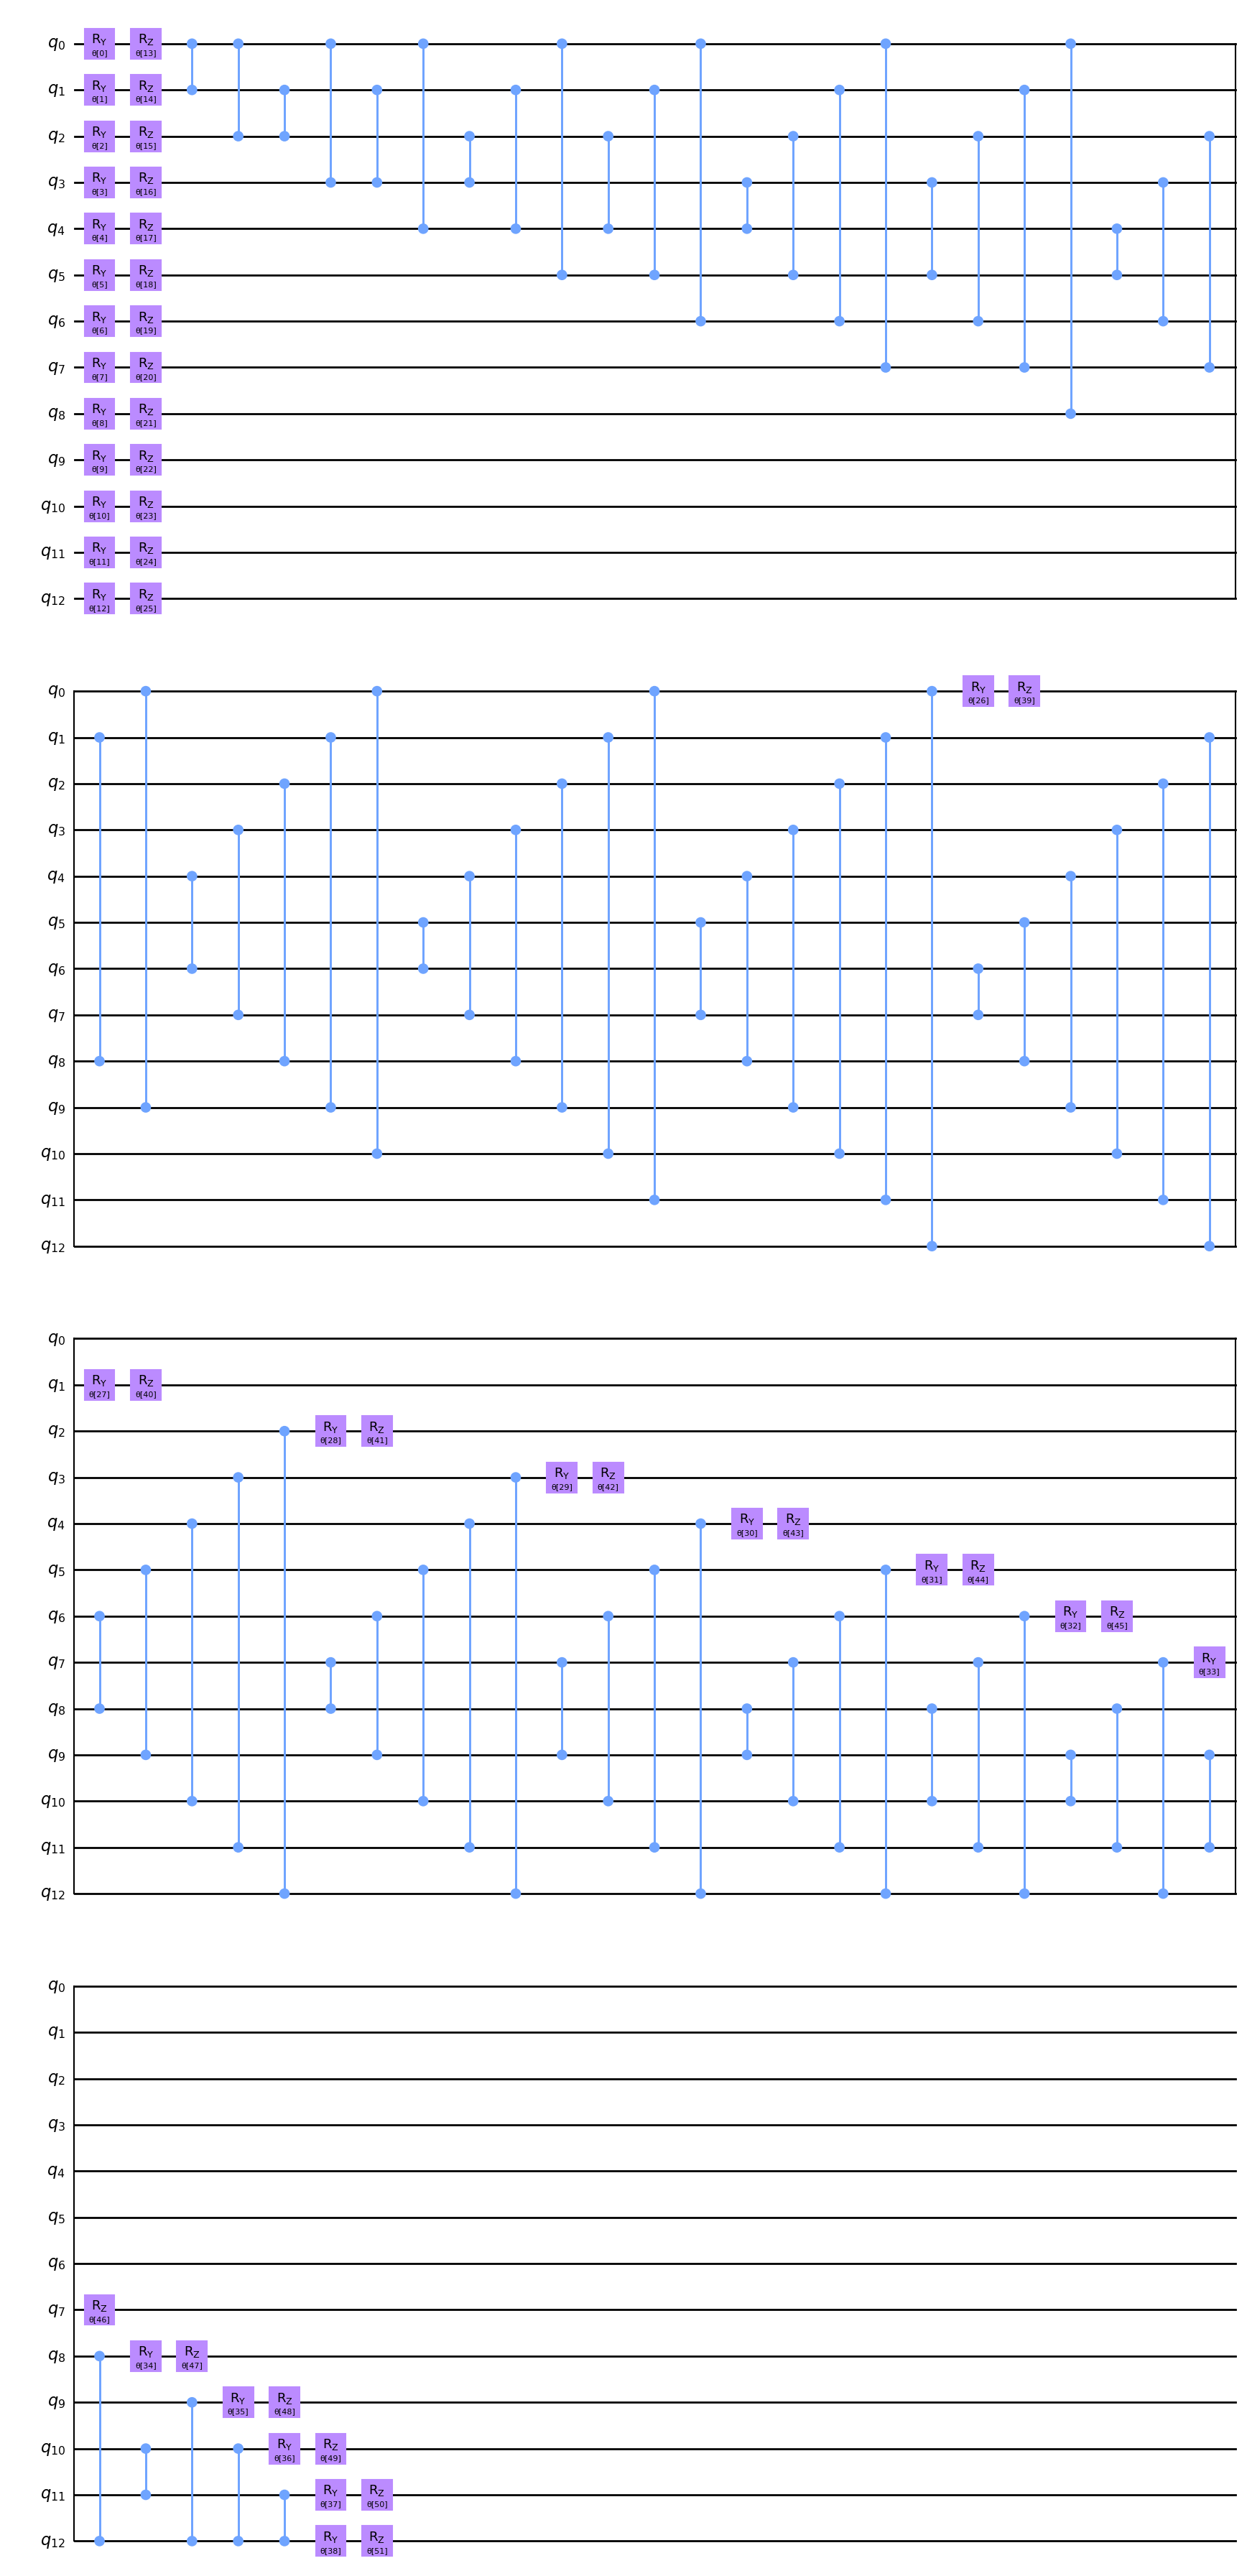

In [16]:
#Para el circuito clasificador utilizaremos TwoLocal
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import PauliTwoDesign

classifier = TwoLocal(13, ['ry', 'rz'], 'cz', reps=1)
classifier.decompose().draw("mpl")




#### Optimizador 

Finalmente, podemos definir un optimizador con el fin de mejorar al máximo posible los resultados obtenido. Para nuestro caso, hemos optado por la implementación del SPSA ?

In [17]:
#Hemos escogido el COBYLA optimizer para que el entrenamiento sea más rápido. Usamos la función de log de los apuntes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import SPSA

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

log = OptimizerLog()


optimizer = SPSA(maxiter=100)

In [ ]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

#Función que define la gráfica a mostrar mientras entrena el modelo

def callback_graph(weights, obj_func_eval):
    clear_output(wait=False)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()



#### VQC

Finalmente, armamos nuestra red neuronal en base a todas las componentes previamente explicadas. La función de pérdida escogida es la cross_entropy. ? 

### Ejecución de la QNN

Ahora, solo resta entrenar la red y graficar sus resultados.

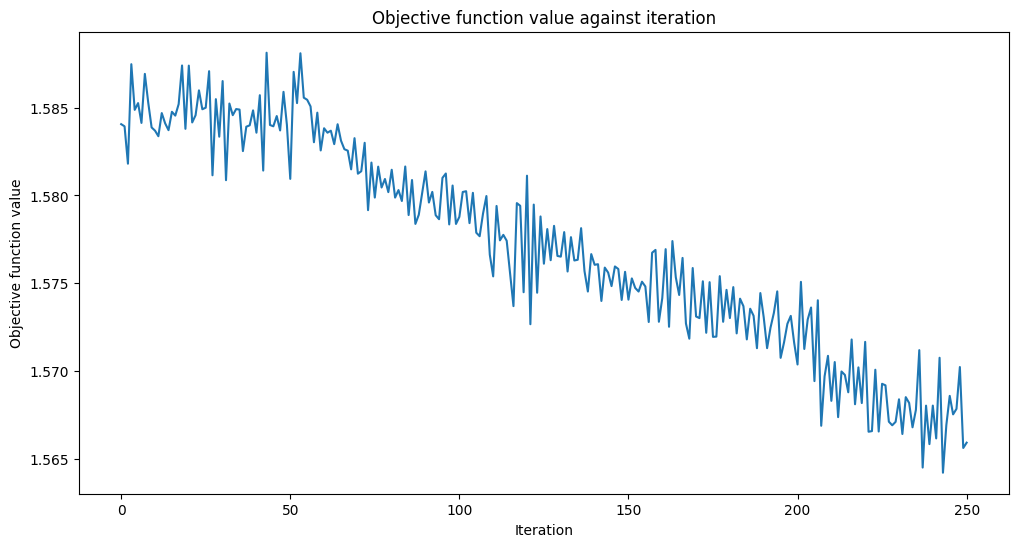

Training time: 5552 seconds


In [99]:

#Entrenamos el modelo

#Caso 1: Classifier TwoLocal, Optimizer SPSA


sampler = Sampler()



vqc = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []
plt.clf()

start = time.time()
vqc.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

#Ploteamos los resultados


In [100]:
train_score_q1 = vqc.score(features_train, labels_train)
test_score_q1 = vqc.score(features_test, labels_test)
 
print(f"Quantum VQC on the training dataset: {train_score_q1:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q1:.2f}")

Quantum VQC on the training dataset: 0.63
Quantum VQC on the test dataset:     0.39


## Variaciones

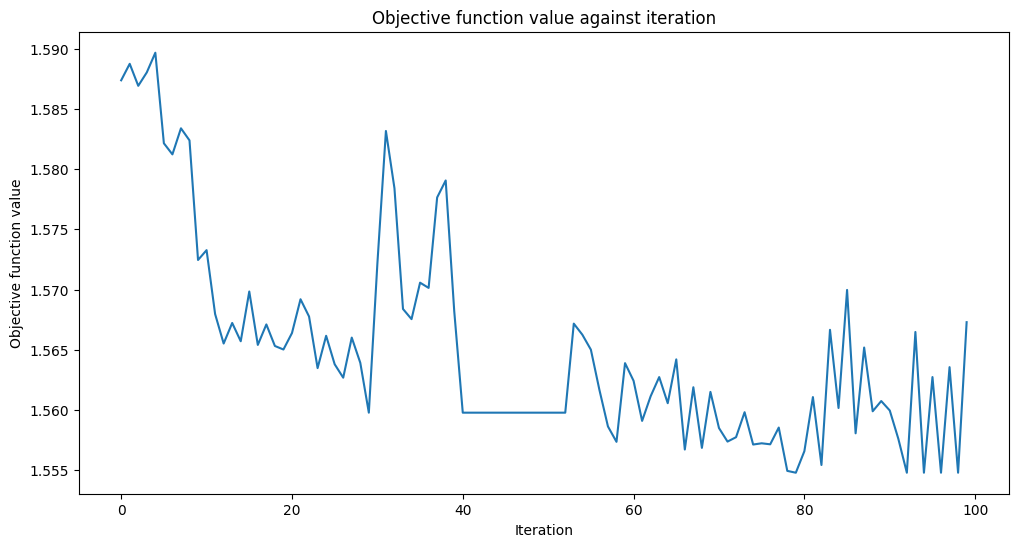

Training time: 2286 seconds


In [37]:

#Caso 2: Classifier TwoLocal, Optimizer COBYLA

classifier = TwoLocal(13, ['ry', 'rz'], 'cz', reps=1)
optimizer = COBYLA(maxiter=100)



vqc2 = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)

plt.clf()

start = time.time()
vqc2.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [39]:

train_score_q2 = vqc2.score(features_train, labels_train)
test_score_q2 = vqc2.score(features_test, labels_test)
 


print(f"Quantum VQC on the training dataset: {train_score_q2:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q2:.2f}")

Quantum VQC on the training dataset: 0.62
Quantum VQC on the test dataset:     0.33


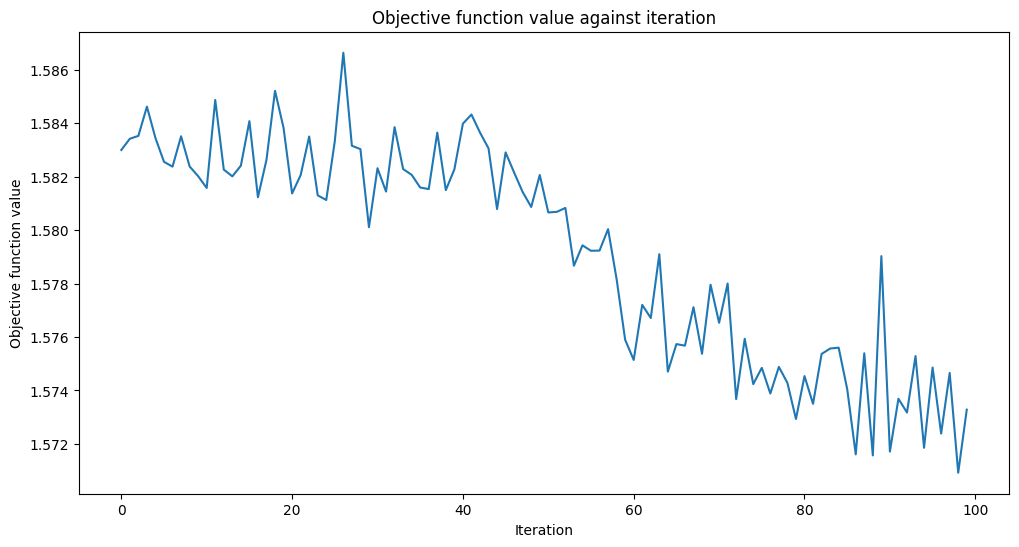

Training time: 2118 seconds


In [45]:
#Caso x: Classifier RealAmplitudes, Optimizer COBYLA

from qiskit.circuit.library import RealAmplitudes

classifier = RealAmplitudes(num_qubits=13, reps=3)
optimizer = COBYLA(maxiter=100)

plt.clf()

vqcx = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)



start = time.time()
vqcx.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [47]:
train_score_qx = vqcx.score(features_train, labels_train)
test_score_qx = vqcx.score(features_test, labels_test)
 
print(f"Quantum VQC on the training dataset: {train_score_qx:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_qx:.2f}")

Quantum VQC on the training dataset: 0.51
Quantum VQC on the test dataset:     0.50


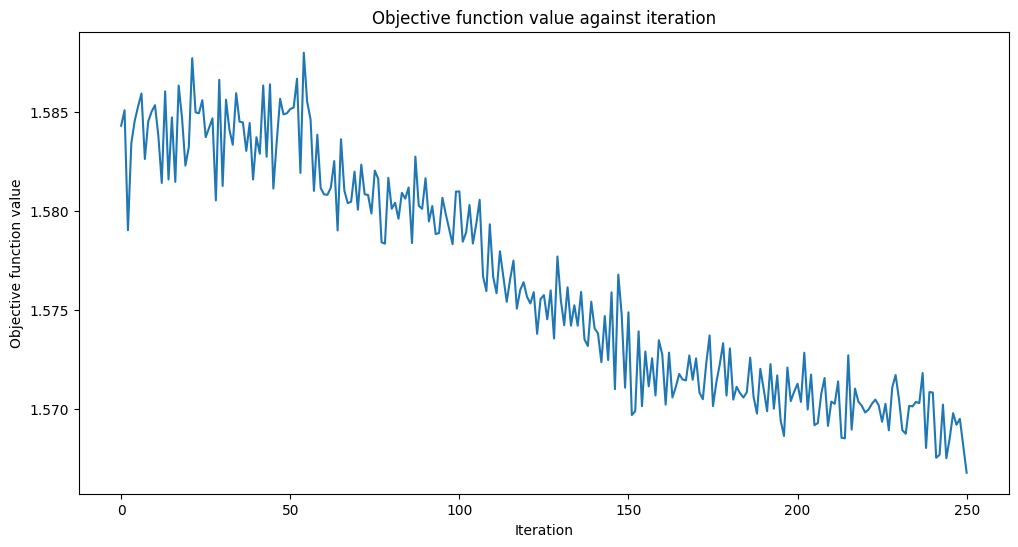

Training time: 5421 seconds


In [87]:

#Caso 3: Classifier PauliTwoDesign, Optimizer SPSA

classifier = PauliTwoDesign(13, reps=1, insert_barriers=False)
optimizer = SPSA(maxiter=100)


plt.clf()


vqc3 = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)


start = time.time()
vqc3.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [91]:
train_score_q3 = vqc3.score(features_train, labels_train)
test_score_q3 = vqc3.score(features_test, labels_test)
 
print(f"Quantum VQC on the training dataset: {train_score_q3:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q3:.2f}")

Quantum VQC on the training dataset: 0.57
Quantum VQC on the test dataset:     0.50


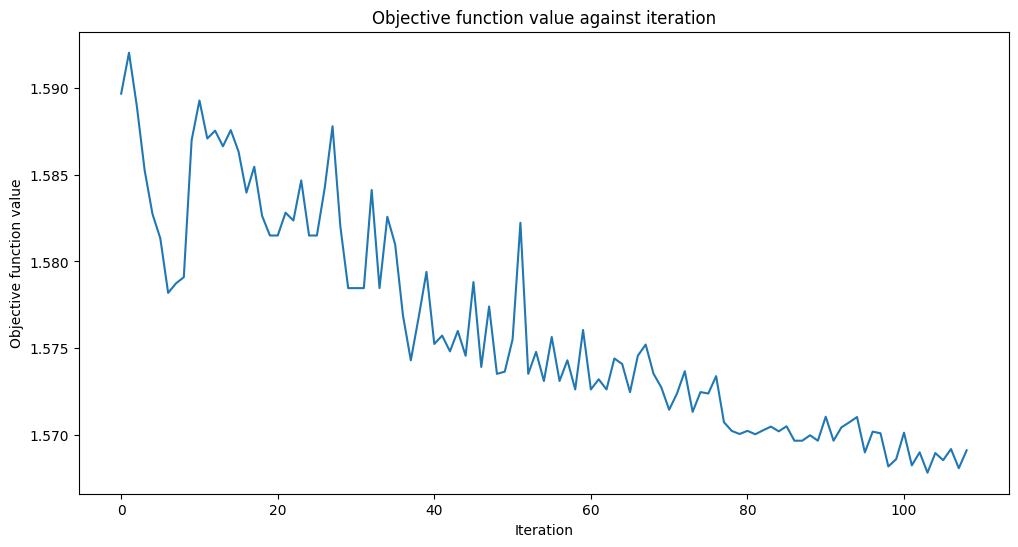

Training time: 1985 seconds


In [21]:

#Caso 4: Classifier PauliTwoDesign, Optimizer COBYLA

classifier = PauliTwoDesign(13, reps=1, insert_barriers=False)
optimizer = COBYLA(maxiter=100)


sampler = Sampler()


vqc4 = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)

plt.clf()

start = time.time()
vqc4.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")


In [81]:

train_score_q4 = vqc4.score(features_train, labels_train)
test_score_q4 = vqc4.score(features_test, labels_test)
 
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.44
Quantum VQC on the test dataset:     0.53


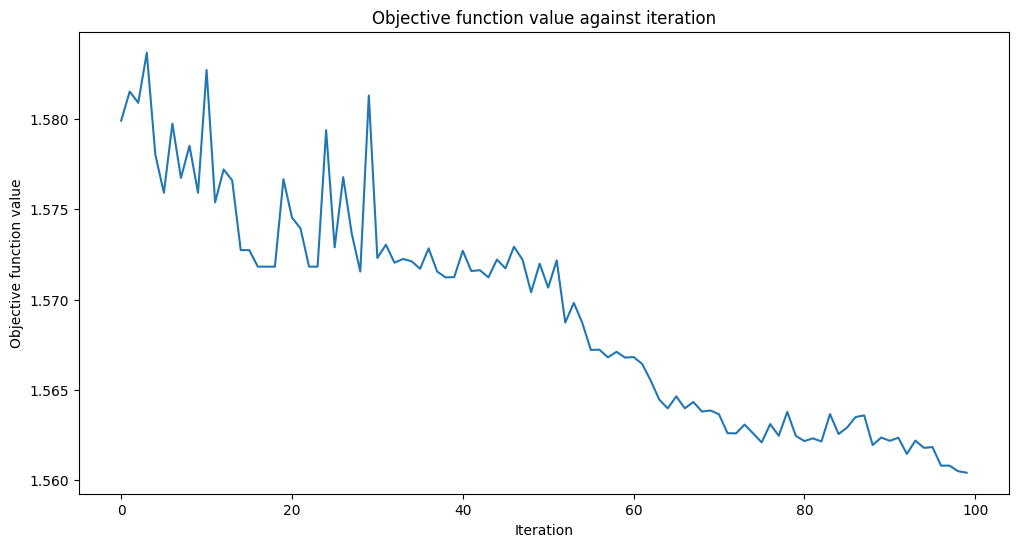

Training time: 2111 seconds
Quantum VQC on the training dataset: 0.58
Quantum VQC on the test dataset:     0.36


In [110]:
from qiskit.circuit.library import PauliFeatureMap
#Caso 4: Classifier PauliTwoDesign, Optimizer COBYLA

featureMap = PauliFeatureMap(feature_dimension=13, reps=1)
classifier = PauliTwoDesign(13, reps=1, insert_barriers=False)
optimizer = COBYLA(maxiter=100)

featureMap = ZZFeatureMap(feature_dimension=13, reps=1)
sampler = Sampler()





vqc5 = VQC(
    sampler=sampler,
    feature_map=featureMap,
    ansatz=classifier,
    optimizer=optimizer,
    callback=callback_graph,
)



start = time.time()
vqc5.fit(features_train, labels_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")



train_score_q5 = vqc5.score(features_train, labels_train)
test_score_q5 = vqc5.score(features_test, labels_test)
 
print(f"Quantum VQC on the training dataset: {train_score_q5:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q5:.2f}")

In [ ]:

train_score_q4 = vqc4.score(features_train, labels_train)
test_score_q4 = vqc4.score(features_test, labels_test)
 
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

### Conclusiones

## Combinaciones que tenemos:

### ZZFeatureMap

    -PauliTwoDesign:
    
        -COBYLA y SPSA
        
    -TwoLocal
    
        -SPSA
        
        -En ejecución: COBYLA

In [52]:
from sklearn.datasets import load_iris
iris_data = load_iris()

In [53]:
features = iris_data.data
labels = iris_data.target

In [54]:
from sklearn.preprocessing import MinMaxScaler
features = MinMaxScaler().fit_transform(features)

In [55]:
print(len(features))

150


__Seaborn visualization library__
* Seaborn is a Python data visualization library based on matplotlib. 
* It provides a high-level interface for drawing attractive and informative statistical graphics.
* As Seaborn compliments and enhances Matplotlib, the learning curve is quite gradual.
* `pairplot` chart:
    - This chart will create a grid of Axes.
    - In the non-diagonal cells we will have a pairwise bivariate distribution of the dataset for the two features involved.
    - In the diagonal cells we will have a univariate distribution plot showing the marginal distribution of the feature involved.

In [56]:
import pandas as pd
import seaborn as sns

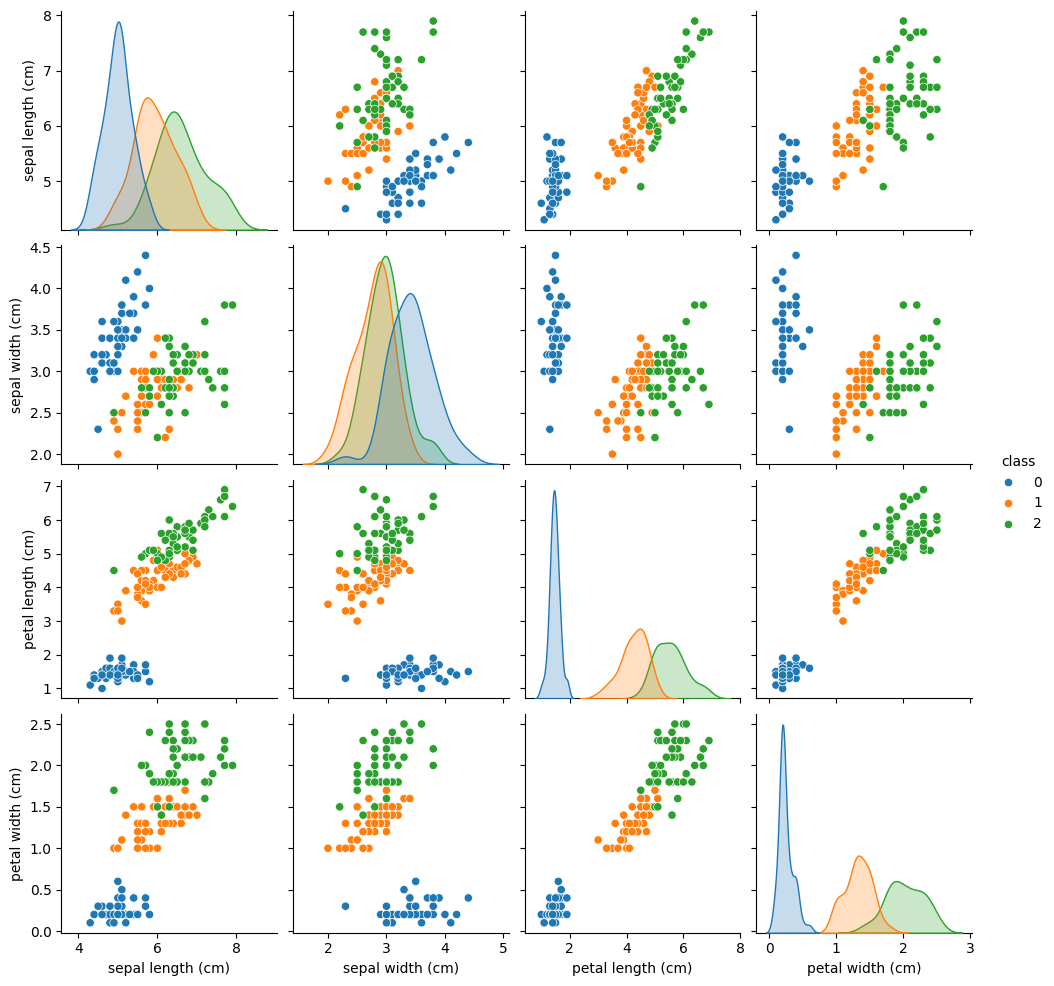

In [57]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

* From the plots, we see that class 0 is easily separable from the other two classes, while classes 1 and 2 are sometimes intertwined, especially regarding the “sepal width” feature.

* Before we train a model, we should split the dataset into two parts: a training dataset and a test dataset. 

In [59]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


#### Quantum encoding

* Our choice of feature map will be the `ZZFeatureMap`. 
* The `ZZFeatureMap` is one of the standard feature maps in the Qiskit circuit library. 
* We pass `num_features` as `feature_dimension`, meaning the feature map will have `num_features` or 4 qubits.
* The parameters $x[0], \dots, x[3]$ are the placeholders for our features.

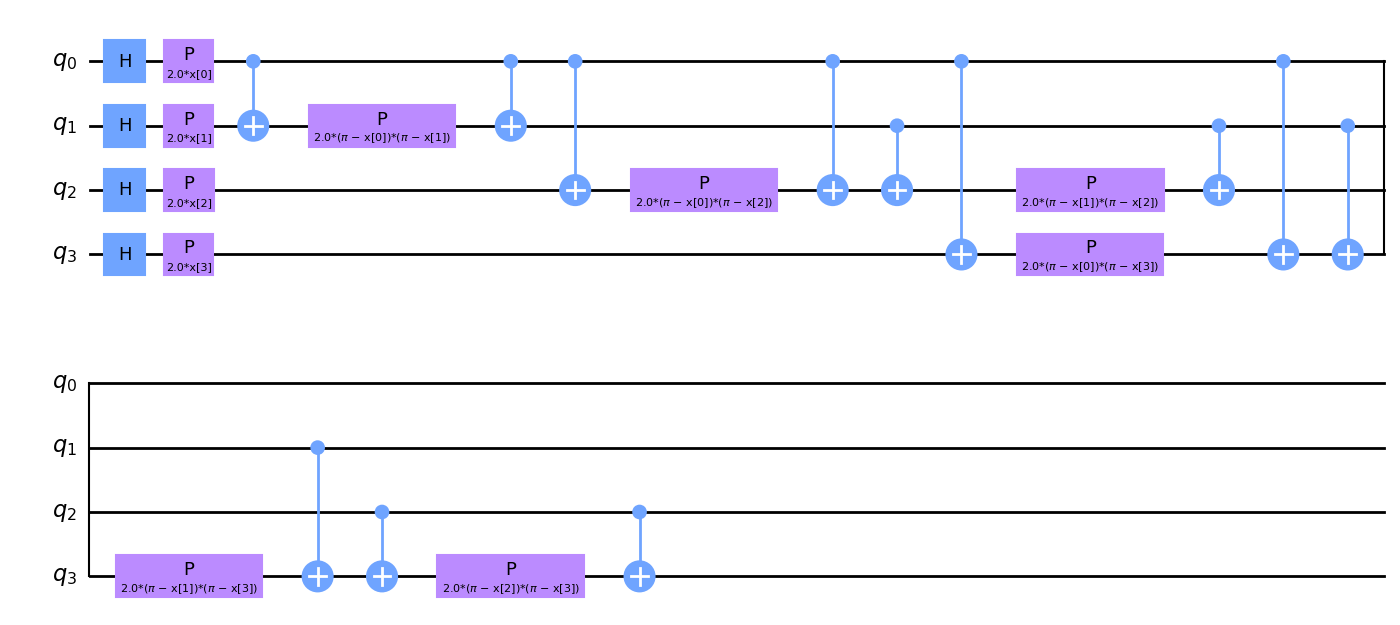

In [78]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]
feature_map = ZZFeatureMap(feature_dimension=4, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

#### Ansatz (the classifier circuit)

* Now we have to create our anstaz or classifier circuit.
* We use the `RealAmplitudes` circuit (a subclass of `TwoLocal`).
* This circuit has 16 parameters named $\theta[0], \dots, \theta[15]$. 
* These are the trainable weights of the classifier.
* More information: https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html

In [77]:
from qiskit.circuit.library import RealAmplitudes

ansatz = TwoLocal(4, ['ry', 'rz'], 'cz', reps=1)


#### Optimizer

* We then choose an optimization algorithm to use in the training process.
* To make the training process faster, we choose a gradient-free optimizer such as COBYLA.
* More information: https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.COBYLA.html#qiskit.algorithms.optimizers.COBYLA

In [73]:

from qiskit.algorithms.optimizers import SPSA
optimizer = SPSA(maxiter=100)

#### Run the VQC

* We need to define the simulator to run the circuit.
* We will use Qiskit primitives as they are the entry point to run QNNs on either a simulator or real quantum hardware. 
* We create an instance of the `Sampler` primitive, that is the reference implementation that is statevector based.
* Using qiskit runtime services you can create a sampler that is backed by a quantum computer.

In [74]:
from qiskit.primitives import Sampler
sampler = Sampler()

* A callback function called `callback_graph` is created to be called by the VQC for each evaluation of the objective function with two parameters: the current weights and the value of the objective function at those weights. 
* Our callback will append the value of the objective function to an array so we can plot the iteration versus the objective function value. 
* The callback will update the plot at each iteration.

In [75]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

* Finally we create the VQC using:
    - The sampler parameter with the simulator backend (it may be omitted, in this case a `Sampler` instance will be created for us.
    - The feature map and the ansatz that form the quantum neural network. 
    - The optimizer.
    - The callback function.
    
* And we run the VQC using the `fit` method.    

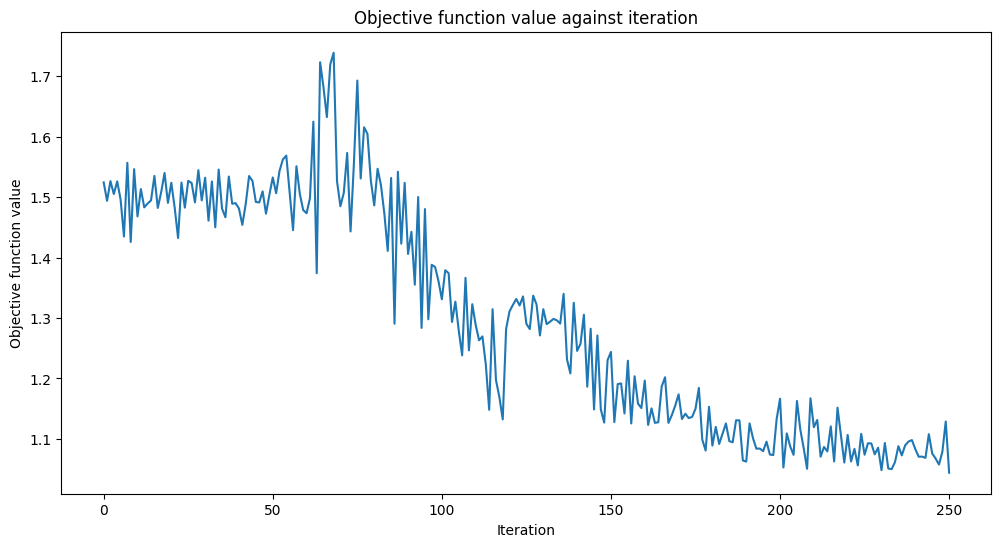

Training time: 190 seconds


In [101]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc_flor = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc_flor.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

* Let’s see how the quantum model performs on the real-life dataset using the `score` method.

In [104]:
train_score_q4 = vqc_flor.score(train_features, train_labels)
test_score_q4 = vqc_flor.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.78
Quantum VQC on the test dataset:     0.80
